In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, save_to_pickle
from datetime import datetime

import seaborn as sns
sns.set_theme(style='white')


import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()



#custom_genes = pd.read_csv('./custom_gene_lists.gmt',sep='\t',encoding = "ISO-8859-1",header=None).drop(columns=[0])
#custom_genes.to_csv('custom_gene_lists_encode_fixed.gmt',index=False,header=None,encoding='utf-8',sep='\t')

### Data downloads

In [2]:
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')

# Get unique region names
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()

# Get unique regions colors
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']

# Rename regions in the data
replace_dict = {'Interferon signaling epithelium':'Intermediate epithelium','Lymphocyte':'Immune'}
for i,r in enumerate(regions):
    if r in replace_dict.keys():
        regions[i] = replace_dict[r]

for sample in samples:
    adata_slides[sample].obs['predicted_region'] = adata_slides[sample].obs['predicted_region'].replace(replace_dict)

# Create color legend
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
color_dict = dict(zip(regions,region_colors))

In [3]:
# Concatenate data for future analyses
concat_adata = ad.concat(adata_slides)
concat_adata.uns['predicted_region_colors'] = region_colors
concat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].astype('category')
concat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].cat.set_categories(regions)


### Scanpy scoring of custom gene sets

In [4]:

gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T
scanpy_res = load_from_pickle('./data/spatial_scanpy_score_results.pkl')
all_obs = pd.concat(scanpy_res,axis=0)

# Concatenate the scoring results into a single anndata
for sample in samples:
    slide = adata_slides[sample]
    slide.obs  = pd.concat([slide.obs,scanpy_res[sample]],axis=1)

all_obs = pd.DataFrame() # Create empty dataframe for obs
for sample in samples:
    all_obs = pd.concat([all_obs,adata_slides[sample].obs.copy()],axis=0)
all_obs['predicted_region'] = all_obs['predicted_region'].astype('category').cat.set_categories(regions)

## Macrophage-persist interaction visualization for Ketola

In [ ]:
from scripts.utils import get_treatment_info
treat_info = get_treatment_info()
untreated_samples = [k for k in treat_info.keys() if treat_info[k] == 'untreated']

In [ ]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn2
sns.set_theme(style='white')



for sample in untreated_samples:

    obs_data = adata_slides[sample].obs.copy()

    def q_therehold_spots(dat,col,quant=0.99):
        q_thr = dat[col].quantile(quant)
        bcode_set = set(dat[dat[col] > q_thr]['sample_id'].index)
        return bcode_set

    # Define your three sets
    set1 = q_therehold_spots(obs_data,'Persist')
    set2 = q_therehold_spots(obs_data,'M1 macrophages')
    set3 = q_therehold_spots(obs_data,'M2 macrophages')


    ##### Spatial plot ##### 


    slide = adata_slides[sample].copy()

    idx_list1 = list(q_therehold_spots(obs_data, 'Persist') - q_therehold_spots(obs_data, 'M1 macrophages') - q_therehold_spots(obs_data, 'M2 macrophages'))
    idx_list2 = list(q_therehold_spots(obs_data, 'M1 macrophages') - q_therehold_spots(obs_data, 'Persist') - q_therehold_spots(obs_data, 'M2 macrophages'))
    #idx_list2 = M1_confident.index.tolist()

    slide.obs['to_plot'] = 'NA'
    slide.obs['to_plot'] = slide.obs['to_plot'].astype('category')

    slide.obs['to_plot'] = slide.obs['to_plot'].cat.set_categories(['M1 macrophages','Persist','NA'])

    slide.obs.loc[idx_list1,'to_plot'] = 'Persist'
    slide.obs.loc[idx_list2,'to_plot'] = 'M1 macrophages' 

    pal = sns.color_palette(['lightgreen','lightcoral','whitesmoke'])

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,12))


    # Create the Venn diagram
    venn3([set1, set2, set3], ('Persist', 'M1 macrophages', 'M2 macrophages'),ax=ax1,set_colors=['lightcoral','lightgreen','lightblue'])

    sc.pl.spatial(slide,color='to_plot',vmin=min, vmax=max,
                                crop_coord=sample_crop_coord[sample],
                                colorbar_loc=None, size=1.3, alpha_img=0.8, palette=pal,
                                ax=ax2,show=False
                                )

    sq.gr.nhood_enrichment(slide, cluster_key="to_plot",show_progress_bar=False)
    sq.pl.nhood_enrichment(slide, cluster_key="to_plot",annotate=True,ax=ax3)

    ax4.axis('off')
    ax4.text(0.3, 0.5, "Persist score q0.95: {:.2f}\nM1 macrophages score q0.95: {:.2f}\nM2 macrophages score q0.95: {:.2f}".format(
        obs_data['Persist'].quantile(0.95),
        obs_data['M1 macrophages'].quantile(0.95),
        obs_data['M2 macrophages'].quantile(0.95)),
        ha='left', va='center',fontsize=16)

    plt.tight_layout()
    plt.savefig('./plots/macrophage_persist_proximity_in_untreated/'+sample+'_multi_panel.pdf')
    plt.clf()

## Plot sample grids 

In [ ]:
# Normalize by the number of cells inferred to be present at each location

cell_types = adata_slides[samples[0]].obs.columns[16:].tolist()

cell_proportions = {}

for sample in samples:
    df = adata_slides[sample].obs[cell_types]
    inferred_cell_numbers = df.sum(axis=1).tolist()
    
    df = df.div(df.sum(axis=1), axis=0)
    df['n_cells'] = inferred_cell_numbers
    cell_proportions[sample] = df.copy()


for sample in samples:
    slide = adata_slides[sample]
    df = cell_proportions[sample]
    for ctype in cell_types:
        slide.obs[ctype] = df[ctype].copy()

    slide.obs['n_cells'] = df['n_cells'].copy()

### Plot proportional inferred cell counts

In [ ]:
# Plot the inferred cell prevalences as a test
# You can plot whichever metric here
for var_to_plot in cell_types:

    it=0

    concat_obs = pd.DataFrame(columns=adata_slides[samples[it]].obs.columns)
    for slide in adata_slides:
        concat_obs = pd.concat([concat_obs,adata_slides[slide].obs.copy()],axis=0)

    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)
    
    min = 0#concat_obs[var_to_plot].quantile(0.05)
    max = 1#concat_obs[var_to_plot].quantile(0.95)


    for i in range(5):
        for j in range(8):
            
            if it < len(samples):
                sc.pl.spatial(adata_slides[samples[it]],color=var_to_plot,title=samples[it],
                            vmin=min, vmax=max,crop_coord=sample_crop_coord[samples[it]],
                            colorbar_loc=None, cmap='viridis', size=1.3, alpha_img=0.8, legend_loc=None,
                            ax=axs[i,j],show=False
                            )

                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)
                it+=1
            else:
                axs[i,j].set_visible(False)

    plt.tight_layout()

    # create a custom axes for the colorbar
    cax = fig.add_axes([0.66, 0.1, 0.3, 0.04])
    # draw the colorbar on the custom axes with horizontal orientation
    fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min, vmax=max), cmap='viridis'), cax=cax, orientation='horizontal')
    cax.set_title(var_to_plot)


    plt.savefig('./plots/all_samples_grid/'+var_to_plot+'_on_all_spatial_sections.pdf')
    plt.clf()


### Plot predicted regions on all samples

In [ ]:
import matplotlib.patches as patches

regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']

# Create color legend
color_dict = dict(zip(regions,region_colors))

# Create an empty list to store legend handles
legend_handles = []

# Iterate over the dictionary items
for name, color in color_dict.items():
    # Create a colored circle patch
    patch = patches.Patch(color=color, label=name)
    # Add the patch to the legend handles list
    legend_handles.append(patch)

In [ ]:

it=0
fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

for i in range(5):
    for j in range(8):
        
        if it < len(samples):
            sc.pl.spatial(adata_slides[samples[it]],color='predicted_region',title=samples[it],
                        crop_coord=sample_crop_coord[samples[it]],
                        size=1.3, alpha_img=0.8, legend_loc=None,
                        ax=axs[i,j],show=False
                        )

            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)

plt.tight_layout()

# create custom axes for the annotation legend 
cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

cax1.axis('off')
cax1.legend(handles=legend_handles[:4],loc='center',markerscale=2,fontsize='x-large')
cax2.axis('off')
cax2.legend(handles=legend_handles[4:],loc='center',markerscale=2,fontsize='x-large')


plt.savefig('./plots/all_samples_grid/predicted_regions_on_all_spatial_sections.pdf')
plt.clf()
#plt.show()


### Plot predicted regions one at a time

In [ ]:

for region_of_interest in regions:
    it=0
    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

    for i in range(5):
        for j in range(8):
            
            if it < len(samples):
                slide = adata_slides[samples[it]].copy()
                slide.obs['region_of_interest'] = np.nan
                slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

                slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

                slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

                try:
                    n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]
                except:
                    n_spots=0

                sc.pl.spatial(slide,color='region_of_interest',title=samples[it]+ ' ({:d})'.format(n_spots),
                            crop_coord=sample_crop_coord[samples[it]],
                            size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                            ax=axs[i,j],show=False
                            )

                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)
                it+=1
            else:
                axs[i,j].set_visible(False)

    plt.tight_layout()

    # create custom axes for the annotation legend 
    cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
    cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

    cax1.axis('off')
    cax1.legend(handles=legend_handles[:4],loc='center',markerscale=2,fontsize='x-large')
    cax2.axis('off')
    cax2.legend(handles=legend_handles[4:],loc='center',markerscale=2,fontsize='x-large')


    plt.savefig('./plots/all_samples_grid/'+region_of_interest+'_region_on_all_spatial_sections.pdf')
    plt.clf()
    #plt.show()


### Plot predicted regions one sample at a time

In [3]:
for sample in samples:
    
    it=0

    fig, axs = plt.subplots(2, 4, figsize=(12, 6),dpi=120)

    slide = adata_slides[sample].copy()

    for i in range(2):
        for j in range(4):
        
            region_of_interest = regions[it]

            if region_of_interest in slide.obs['predicted_region'].unique():
                
                slide.obs['region_of_interest'] = np.nan

                slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

                slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

                slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

            
                n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]

                sc.pl.spatial(slide,color='region_of_interest',title=region_of_interest+ ' ({:d})'.format(n_spots),
                        crop_coord=sample_crop_coord[sample],
                        size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                        ax=axs[i,j],show=False
                        )
                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)

            else:
                axs[i,j].set_visible(False)
            
            it+=1
    
    plt.tight_layout()
    plt.savefig('./plots/all_samples_grid/region_based/sample_specific/'+sample+'_all_regions_individually.pdf')
    plt.clf()
    #plt.show()


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

## Single sample expression categorized by region (heatmap 2b)

In [ ]:
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')


In [ ]:
from scipy.stats import zscore

# Specific slide or all data?
sample = 'PC_06_04581_OIK_POST_0'
slide = adata_slides[sample].copy()
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
#slide = ad.concat(adata_slides)


sc.tl.rank_genes_groups(slide,groupby='predicted_region',method='wilcoxon')

spots_list = []
region_spans = {}
prev_region = ''

for region in regions:
    lst = slide.obs[slide.obs['predicted_region'] == region].index.tolist()
    spots_list += lst
    if prev_region != '':
        region_spans[region] = region_spans[prev_region] + len(lst)
    else:
        region_spans[region] = len(lst)
    prev_region = region

region_pos = list(region_spans.values())


In [ ]:
n_genes = 50
gene_list = []
row_lines = []

for i in range(n_genes, n_genes*len(regions)+1, n_genes):
    row_lines.append(i)

for region in regions:
    deg_res = sc.get.rank_genes_groups_df(slide,group=region)

    deg_res = deg_res[~deg_res['names'].isin(gene_list)] # Take out genes that are already used as markers
    deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
    deg_res = deg_res[~deg_res['names'].str.startswith('MT')]

    deg_res_sorted = deg_res.sort_values(['scores'],ascending=False).reset_index(drop=True)
    gene_list += deg_res_sorted[:n_genes]['names'].tolist()
genes_as_series = pd.Series(gene_list)
#genes_as_series = genes_as_series[~genes_as_series.duplicated()]


dat = slide[:,genes_as_series.tolist()].X.copy().T
#dat = slide[:,genes_as_series.tolist()].layers['counts'].todense().T
df_to_plot = pd.DataFrame(data=dat,columns=slide.obs_names,index=genes_as_series.tolist())[spots_list]


df_to_plot = df_to_plot.apply(zscore,axis=1)

In [ ]:
sns.set_theme(style='whitegrid')
fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_to_plot,cmap='viridis',xticklabels=False,yticklabels=False,vmin=-1, vmax=2)
ax.vlines(region_pos,colors='white', lw=0.5, ymin=-1, ymax=df_to_plot.shape[0])
ax.hlines(row_lines,colors='white', lw=0.5, xmin=-1, xmax=df_to_plot.shape[1])

plt.savefig('./plots/'+sample+'_region_expression_heatmap.png',dpi=800)
plt.show()

In [ ]:
# Barplot of the numer of spots belonging to each region
concat_obs = pd.DataFrame()
for sample in samples:
    concat_obs = pd.concat([concat_obs,adata_slides[sample].obs.copy()],axis=0)

plt.figure(figsize=(3,3))
barplot_df = concat_obs.predicted_region.value_counts().loc[regions]
barplot_df.plot.bar(color=region_colors,width=1)
plt.axhline(y=10000,linestyle='--',color='black',linewidth=1)
plt.axhline(y=20000,linestyle='--',color='black',linewidth=1)
plt.xticks(rotation=60)
plt.savefig('./plots/region_prevalence_barplot.pdf')

## Visualize score region enrichments and expression

In [ ]:
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')

### Looking at region proportions (% of spots belonging to a region) across treatment classes (swarmplot)

In [ ]:
from scripts.utils import get_treatment_info
treat_info = get_treatment_info()
concat_obs = concat_adata.obs.copy()
concat_obs['treatment'] = concat_obs['sample_id'].map(treat_info)


def get_spot_proportions(region,sample_list=samples,slides=adata_slides,treatment_info=treat_info):
    df = pd.DataFrame(index=samples,columns=[region + ' spots','total spots','treatment'])
    for sample in sample_list:
        df.loc[sample,'total spots'] = len(adata_slides[sample])
        df.loc[sample,region + ' spots'] = len(slides[sample][slides[sample].obs['predicted_region'] == region])
    df['proportion'] = df[region+' spots'] / df['total spots']
    df['treatment'] = df.index.map(treatment_info)


    df['treatment'] = df['treatment'].astype('category')    
    df['proportion'] = df['proportion'].astype(float)

    return(df)


In [ ]:
sns.set_theme(style='whitegrid')
order = ['bph', 'untreated', 'bicalutamide', 'goserelin']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

for i, region in enumerate(regions):
    row = i // 4
    col = i % 4
    ax = axes[row][col]

    df = get_spot_proportions(region)

    sns.stripplot(x="treatment", y="proportion", order = order, data=df, size=4, color=".7",ax=ax)
    sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="treatment",
            y="proportion",
            data=df,
            order = order,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)
    ax.set_ylim(0,1)
    ax.set_title(region)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=15)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_ind

for reg in regions:
    df = get_spot_proportions(reg)

    vec1 = df[df['treatment']=='untreated']['proportion']
    vec2 = df[(df['treatment']=='bicalutamide') | (df['treatment']=='goserelin')]['proportion']
    stat, pval = ttest_ind(vec1, vec2)
    print(reg + ' proportion in untreated vs treated: {:.2e}'.format(pval))

### Looking at the marker genes of a specific region independently one sample at a time (dotplot 2b)

In [4]:
# Calculate DEGs between regions individually in samples
# This takes several minutes with method='wilcoxon',
# About a minute with method='t-test'
for sample in samples:

    slide = adata_slides[sample]#.copy()

    # Remove a group if it has less than 10 spots in it
    val_counts = slide.obs['predicted_region'].value_counts()
    category_groups = val_counts[~(val_counts < 10)].index.tolist()

    sc.tl.rank_genes_groups(slide,groupby='predicted_region', method='wilcoxon',groups=category_groups,random_state=25813063)


In [5]:
from scripts.utils import get_sample_id_mask
masked_sample_ids = get_sample_id_mask()

# Take a region one at a time, extract DEG results, save into a list

region_degs_dict = {}
for region in regions:
    deg_res_all = pd.DataFrame()

    for sample in samples:

        slide = adata_slides[sample]

        try:
            deg_res = sc.get.rank_genes_groups_df(slide,group=region)

            deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
            deg_res = deg_res[~deg_res['names'].str.startswith('MT')]
            deg_res['sample'] = sample #masked_sample_ids[sample]
            deg_res = deg_res[(deg_res['pvals_adj']<0.05) & (deg_res['logfoldchanges']>=1)].reset_index(drop=True)


            deg_res_all = pd.concat([deg_res_all,deg_res],axis=0)
        except:
            continue

    region_degs_dict[region] = deg_res_all

region_degs_dict

{'Tumor':        names     scores  logfoldchanges         pvals     pvals_adj    sample
 0       KLK2  10.062733        1.197933  8.072625e-24  7.500276e-21   BPH_665
 1       ACPP   9.665845        1.120208  4.211299e-22  2.898310e-19   BPH_665
 2      PRAC1   9.629808        1.350669  5.984080e-22  3.971292e-19   BPH_665
 3    TMPRSS2   8.044575        1.105189  8.654542e-16  3.282014e-13   BPH_665
 4    SLC45A3   7.621521        1.065015  2.507043e-14  8.470158e-12   BPH_665
 ..       ...        ...             ...           ...           ...       ...
 619    SYTL5   2.258399        1.184282  2.392076e-02  4.698317e-02  CRPC_531
 620     PUS3   2.257908        1.008102  2.395137e-02  4.703787e-02  CRPC_531
 621   IFNLR1   2.257827        1.466179  2.395648e-02  4.704246e-02  CRPC_531
 622    BEND6   2.247758        1.189201  2.459161e-02  4.823401e-02  CRPC_531
 623     MNX1   2.242028        1.290908  2.495954e-02  4.890495e-02  CRPC_531
 
 [14924 rows x 6 columns],
 'Luminal epit

In [28]:
date = datetime.now().strftime('%y%m%d')
save_to_pickle(region_degs_dict,'./data/region_gene_markers_signif_degs_'+date+'.pkl')

In [6]:
region_sample_counts = {}
df_gene_counts = pd.DataFrame()
for r in regions:
    df_gene_counts = pd.merge(region_degs_dict[r]['names'].value_counts().rename(r),df_gene_counts,left_index=True,right_index=True,how='outer')
    region_sample_counts[r] = len(region_degs_dict[r]['sample'].unique())
df_gene_counts = df_gene_counts.fillna(0).astype(int)


In [17]:
# Take DEG results and perform enrichment analysis:
# Check in how many samples this gene is overexpressed in a specific region
# Compare this to how many samples the same gene is overexpressed in 
# If there is a significant enrichment for this marker in a region, it can be considired region specific


from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

signif_pval_interactions = {}

for reg in regions:
    
    df = df_gene_counts.copy()
    other_keys = [c for c in df.columns if c != reg]

    n_sample = region_sample_counts[reg]
    n_control = pd.Series([region_sample_counts[k] for k in other_keys]).sum()

    df = df.sort_index()

    # Perform Fisher's exact test on all 
    for iact in df.index:
        a = df[reg].loc[[iact]]
        c = df[other_keys].sum(axis=1).loc[[iact]]
        b = n_sample-a
        d = n_control-c
        arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
        stat,pval = fisher_exact(arr,alternative='greater')
        df.loc[[iact],'pval'] = pval

    df['adj_pval'] = multipletests(df['pval'],method='fdr_bh')[1]


    df_signif = pd.DataFrame({'interaction':df.index.tolist(),
                                'active_in':df[reg].astype(int).tolist(),
                                'adj_pval':df['adj_pval'].tolist(),
                                'interface':np.repeat(reg,len(df))})

    signif_pval_interactions[reg] = df_signif.copy()


date = datetime.now().strftime('%y%m%d')
save_to_pickle(signif_pval_interactions,'./data/region_gene_markers_fishers_exact_test_'+date+'.pkl')

In [ ]:
# Save the results into an excel-file

# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/supp_table_3.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in region_degs_dict.items():
    # Write each dataframe to a separate sheet in the Excel file
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()


In [38]:
marker_genes_for_hmap = ['PRAC1','HPN','PCAT14','GDF15','GOLM1', # Tumor
                         'MSMB','ACPP','RDH11','NKX3-1','AZGP1', # Luminal
                         'KRT5','KRT15','TRIM29','SLC14A1','TP63', # Basal 
                         'MMP7','PIGR','LTF','CP','KRT7', # Intermediate
                         'CXCR4','TRBC1','TRBC2','PTPRC','CD52', # Lymphocyte
                         'EPAS1','EMP1','VWF','PECAM1','IFI27', # Endothelium
                         'DCN','LUM','FBLN1','SFRP2','COL1A1', # Fibroblast
                         'TAGLN','ACTA2','ACTG2','MYH11','MYL9' # Muscle
                         ]

In [39]:
plot_df = pd.DataFrame()
for region in regions:
    degs = region_degs_dict[region]
    n_samples = len(degs['sample'].unique())
    
    degs = degs[degs['names'].isin(marker_genes_for_hmap)]
    
    mean_lfc_list = []
    proportion_degs_list = []

    for gene in marker_genes_for_hmap:

        if gene in degs['names'].values:
            mean_lfc = degs[degs['names'] == gene]['logfoldchanges'].mean()
            proportion_degs = degs['names'].value_counts()[gene] / n_samples
            mean_lfc_list.append(mean_lfc)
            proportion_degs_list.append(proportion_degs)
        
        else:
            mean_lfc_list.append(np.nan)
            proportion_degs_list.append(0)
    
    df = pd.DataFrame({'mean_logfoldchange': mean_lfc_list,'pct_deg_in': proportion_degs_list, 'region': region},index = marker_genes_for_hmap)
    plot_df = pd.concat([plot_df,df],axis=0)

plot_df['genes'] = plot_df.index.astype(str)

plot_df.loc[plot_df['pct_deg_in']==0,'pct_deg_in'] = np.nan

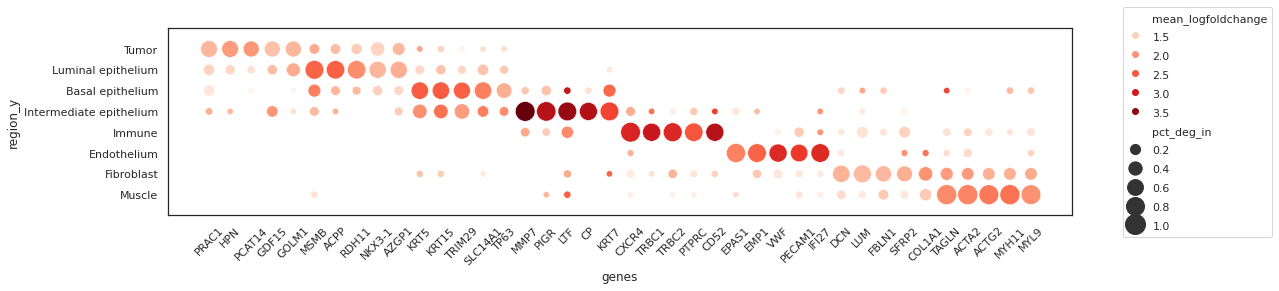

In [41]:

# Create the dotplot
sns.set(style='white')

width = 18
height = 4

fig, ax = plt.subplots(figsize=(width, height))
yticks_list = list(np.arange(2,(len(regions)*2)+2,2)[::-1])


# Get control over interactions order and gap
plot_df['region_y'] = plot_df['region'].map(dict(zip(regions,yticks_list)))
sns.scatterplot(x='genes', y='region_y', size='pct_deg_in', hue='mean_logfoldchange', 
                data=plot_df, sizes=(40, 400), palette='Reds', ax=ax,legend=True,
                )

plt.ylim(0,yticks_list[0]+2)
plt.yticks(yticks_list,regions)
plt.xticks(rotation=45)
plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

plt.savefig('./plots/region_gene_markers_dotplot.pdf')
plt.show()


In [ ]:
# Plot as a heatmap

plot_df = pd.DataFrame(index=regions,columns=marker_genes_for_hmap,dtype=int)

for gene in marker_genes_for_hmap:
    for region in regions:
 
        region_degs = region_degs_dict[region].copy()

        region_deg_val_counts = region_degs['names'].value_counts()

        if gene not in region_deg_val_counts.index:
            plot_df.loc[region,gene] = 0
        else:
            plot_df.loc[region,gene] = region_deg_val_counts.loc[gene]
            
fig,ax = plt.subplots(figsize=(15,5))
sns.heatmap(plot_df,square=True,cmap='Reds',annot=False,vmax=len(samples),ax=ax)
plt.savefig('./plots/all_samples_tissue_region_marker_genes.pdf')


In [42]:
plot_df.to_excel('./source_data/figure_2d.xlsx',engine='xlsxwriter')

### Plot expresison violins for multiple markers in multiple regions (alternative violinplot 2d)

In [ ]:
# Get the top n genes for each region and save them into a list

gene_list = []
n_genes = 10

for region in regions:
    deg_res = sc.get.rank_genes_groups_df(concat_adata,group=region)

    #deg_res = deg_res[~deg_res['names'].isin(gene_list)] # Take out genes that are already used as markers
    deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
    deg_res = deg_res[~deg_res['names'].str.startswith('MT')]

    deg_res_sorted = deg_res.sort_values(['scores'],ascending=False).reset_index(drop=True)
    #deg_res_sorted = deg_res.sort_values(['logfoldchanges'],ascending=False)[deg_res['pvals_adj']<0.05].reset_index(drop=True)
    gene_list += deg_res_sorted[:n_genes]['names'].tolist()

origin = [item for sublist in [np.repeat(region,n_genes).tolist() for region in regions] for item in sublist]
genes_df = pd.DataFrame(gene_list,origin,columns=['gene'])


In [ ]:
sns.set_theme(style='whitegrid')
for region in regions:
    gene_list = genes_df.loc[region]['gene']
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(24, 6))

    for i, gene in enumerate(gene_list):
        row = i // 5
        col = i % 5
        ax = axs[row, col]
        sc.pl.violin(concat_adata, keys=gene, groupby='predicted_region', order=regions, rotation=20, jitter=False, inner='box', ax=ax,show=False, use_raw=True)#,layer='counts')
        ax.set_ylim(0, 6)
        
    plt.tight_layout()
    #plt.show()
    plt.savefig('./plots/gene_violins/'+region + '_top_genes_violin_plots.png',dpi=120)
    plt.clf()


In [ ]:
concat_adata = ad.concat(adata_slides,join='outer')

In [ ]:
concat_adata.uns['predicted_region_colors'] = region_colors
concat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].cat.set_categories(regions)

# This list of genes is from 
custom_gene_list = ['RACK1','PRAC1','EEF2', # Tumor
                    'MSMB','KLK2','ACPP', # Luminal
                    'KRT5','KRT15','TP63', # Basal
                    'LTF','ANXA2','KRT19', # Intermed
                    'CD74','HLA-DRA','TRBC2', # Lymphocyte
                    'VWF','IFI27','A2M', # Endothelium
                    'DCN','LUM','FBLN1', # Fibroblast
                    'MYL9','ACTA2','TPM2'] # Muscle

In [ ]:
sns.set_theme(style='whitegrid')

fig, axs = plt.subplots(nrows=3, ncols=8, figsize=(24, 6))

for i, gene in enumerate(custom_gene_list):
    col = i // 3
    row = i % 3
    ax = axs[row, col]
    sc.pl.violin(concat_adata, keys=gene, groupby='predicted_region', order=regions, jitter=False, inner='box', ax=ax,show=False, use_raw=True)#,layer='counts')
    ax.set_ylim(0, 6)
    
plt.tight_layout()
#plt.savefig('./plots/gene_violins/custom_genes_of_interest_top_genes_violin_plots.pdf')
plt.savefig('./plots/gene_violins/custom_genes_of_interest_top_genes_violin_plots.png',dpi=600)
plt.clf()


## Visualize score enrichments in regions (violin plots)

In [ ]:
gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
scanpy_res = load_from_pickle('./data/spatial_scanpy_score_results.pkl')

In [ ]:
# Concatenate the scoring results into a single anndata
for sample in samples:
    slide = adata_slides[sample]
    slide.obs  = pd.concat([slide.obs,scanpy_res[sample]],axis=1)

df = pd.DataFrame() # Create empty dataframe for obs
for sample in samples:
    df = pd.concat([df,adata_slides[sample].obs.copy()],axis=0)

# You could take whichever sample, just get the region order    
regions = adata_slides[samples[10]].obs['predicted_region'].cat.categories.tolist() 
df['predicted_region'] = df['predicted_region'].astype('category').cat.set_categories(regions)

### Plot the aggragated regions 

In [ ]:
from scipy.stats import ttest_1samp
sns.set_theme(style='whitegrid')
sns.set_palette(region_colors)

# Rename regions in the data
replace_dict = {'Interferon signaling epithelium':'Intermediate epithelium','Lymphocyte':'Immune'}
for i,r in enumerate(regions):
    if r in replace_dict.keys():
        regions[i] = replace_dict[r]

n_rows = len(gene_set_df.columns)

fig, axs = plt.subplots(n_rows, 1, figsize=(10, 4*n_rows), dpi=120)

# Loop over each category and plot on a separate subplot
for i, col in enumerate(gene_set_df.columns):

    df_to_plot = df[['sample_id',col,'predicted_region']]

    # RENAMING CATEGORIES
    df_to_plot['predicted_region'] = df_to_plot['predicted_region'].replace(replace_dict)
    
    ax = axs[i]

    # Plot quantile lines to keep track of how the score behaves

    score_median = df_to_plot[col].quantile(0.5)

    ax.axhline(score_median, linestyle='--', color='black') 

    sns.violinplot(data=df_to_plot, x='predicted_region', y=col,ax=ax)
    ax.set(ylim=(-0.5, 1.5))
    
    for idx,reg in enumerate(regions):

        reg_scores = df_to_plot[df_to_plot['predicted_region']==reg][col]

        if ttest_1samp(reg_scores,0,axis=None,alternative='greater')[1] <0.01:

            t_stat, p_val = ttest_1samp(reg_scores,score_median,axis=None,alternative='greater')

            ## Make p-value and magnitude requirements
            if p_val<0.01 and ((score_median < reg_scores.quantile(0.05))):
                asterisks = '***'
            elif p_val<0.01 and ((score_median < reg_scores.quantile(0.15))):
                asterisks = '**'
            elif p_val<0.01 and ((score_median < reg_scores.quantile(0.25))):
                asterisks = '*'
            else:
                asterisks = ''
                
            ax.text(idx, 1.55, asterisks, fontsize=20,ha='center', va='center')
            
            #print(reg + ' t-test p-value: {:.2e}'.format(p_val))

    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    ax.legend(loc='lower right')
    
plt.tight_layout()
plt.savefig('./plots/score_violins/scanpy_scores_by_region_enrichment.pdf')
plt.clf()
#plt.show()

## Visualize score differences prior to and after treatment (violin plots)

In [5]:
gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
scanpy_res = load_from_pickle('./data/spatial_scanpy_score_results.pkl')

In [6]:
# Concatenate the scoring results into a single anndata
for sample in samples:
    slide = adata_slides[sample]
    slide.obs  = pd.concat([slide.obs,scanpy_res[sample]],axis=1)

df = pd.DataFrame() # Create empty dataframe for obs
for sample in samples:
    df = pd.concat([df,adata_slides[sample].obs.copy()],axis=0)

# You could take whichever sample, just get the region order    
regions = adata_slides[samples[10]].obs['predicted_region'].cat.categories.tolist() 
df['predicted_region'] = df['predicted_region'].astype('category').cat.set_categories(regions)

In [7]:
from scripts.utils import get_treatment_info
treat_info = get_treatment_info()
pca_samples = []
for k in treat_info:
    if treat_info[k] == 'untreated':
        pca_samples.append(k)

for k in treat_info:
    if treat_info[k] == 'bicalutamide':
        pca_samples.append(k)        

for k in treat_info:
    if treat_info[k] == 'goserelin':
        pca_samples.append(k)        

df['treatment'] = df['sample_id'].map(treat_info)

### Plot the aggragated regions according to treatment class

In [8]:
from scipy.stats import ttest_ind
sns.set_theme(style='whitegrid')

# Rename regions in the data
replace_dict = {'Interferon signaling epithelium':'Intermediate epithelium','Lymphocyte':'Immune'}
for i,r in enumerate(regions):
    if r in replace_dict.keys():
        regions[i] = replace_dict[r]

n_rows = len(gene_set_df.columns)

fig, axs = plt.subplots(n_rows, 1, figsize=(12, 4*n_rows), dpi=120)

# Loop over each category and plot on a separate subplot
for i, col in enumerate(gene_set_df.columns):

    df_to_plot = df[['sample_id',col,'treatment','predicted_region']][df['sample_id'].isin(pca_samples)]

    df_to_plot['sample_id'] = df_to_plot['sample_id'].astype('category').cat.set_categories(pca_samples)

    df_to_plot['treatment'] = df_to_plot['treatment'].replace(['bicalutamide', 'goserelin'], 'treated')

    # RENAMING CATEGORIES
    df_to_plot['predicted_region'] = df_to_plot['predicted_region'].replace(replace_dict)
    
    ax = axs[i]

    # Plot quantile lines to keep track of how the score behaves
    ax.axhline(df_to_plot[df_to_plot['treatment']=='untreated'][col].quantile(0.9), linestyle='--', color=sns.color_palette()[0]) 
    ax.axhline(df_to_plot[df_to_plot['treatment']=='treated'][col].quantile(0.9), linestyle='--', color=sns.color_palette()[1]) 

    ax = sns.violinplot(data=df_to_plot, x='predicted_region', y=col, hue='treatment',ax=ax)
    ax.set(ylim=(-0.5, 1.5))

    for idx,reg in enumerate(regions):

        groups = [group[col] for name, group in df_to_plot[df_to_plot['predicted_region']==reg].groupby('treatment')]
        f_stat, p_val = ttest_ind(*groups)

        ## Make p-value and magnitude requirements
        if p_val<0.01 and ((groups[0].quantile(0.50) > groups[1].quantile(0.95)) or (groups[0].quantile(0.50) < groups[1].quantile(0.05))):
            asterisks = '***'
        elif p_val<0.01 and ((groups[0].quantile(0.50) > groups[1].quantile(0.85)) or (groups[0].quantile(0.50) < groups[1].quantile(0.15))):
            asterisks = '**'
        elif p_val<0.01 and ((groups[0].quantile(0.50) > groups[1].quantile(0.75)) or (groups[0].quantile(0.50) < groups[1].quantile(0.25))):
            asterisks = '*'
        else:
            asterisks = ''
            
        ax.text(idx, 1.55, asterisks, fontsize=20,ha='center', va='center')
        
        #print(reg + ' t-test p-value: {:.2e}'.format(p_val))

    ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
    ax.legend(loc='lower right')
    
plt.tight_layout()
plt.savefig('./plots/score_violins/scanpy_scores_by_regions_PCa_treatment.pdf')
plt.clf()
#plt.show()

<Figure size 1440x40320 with 0 Axes>

## Visualize gene overlap between gene lists and samples (QC to determine the scoring validity)

In [ ]:
gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T

In [ ]:
intersections = pd.DataFrame(index=samples,columns=gene_set_df.columns)
for sample in samples:
    for col in gene_set_df.columns:
        size = len(set(adata_slides[sample].var_names).intersection(set(gene_set_df[col])))
        intersections.loc[sample,col] = size
for col in gene_set_df.columns:
    n_genes = intersections[col].max()
    intersections[col] = intersections[col]/intersections[col].max()
    intersections[col] = intersections[col].astype(float)
    intersections = intersections.rename(columns={col:col + ' ('+str(n_genes)+')'})
    

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(intersections, cmap='bwr',square=True,ax=ax,vmax=1.1)
plt.title('Proportion of maximum number of genes (in columns) used to score each sample \n on each custom gene list')

In [ ]:
# Mean number of counts 
mean_n_counts = pd.DataFrame(index=samples,columns=gene_set_df.columns)
for sample in samples:
    for col in gene_set_df.columns:
        genes = list(set(adata_slides[sample].var_names).intersection(set(gene_set_df[col])))
        mean = adata_slides[sample][:,genes].layers['counts'].mean()
        mean_n_counts.loc[sample,col] = mean

for col in mean_n_counts.columns:
    mean_n_counts[col] = mean_n_counts[col].astype(float)
    mean_n_counts = mean_n_counts.rename(columns={col:col + ' ({:.1e})'.format(mean_n_counts[col].mean())})

In [ ]:
sns.clustermap(mean_n_counts, z_score=1, cmap='bwr',square=True,figsize=(12,12))
plt.title('Z-score (column) of mean counts for genes in each set in each sample')

In [ ]:
for i,col in enumerate(gene_set_df.columns):
    mean_n_counts = mean_n_counts.rename(columns={mean_n_counts.columns[i]:col})

In [ ]:
print('Mean of raw counts of each gene set')
print(mean_n_counts.mean().sort_values())

In [ ]:
gene_sets = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).index.tolist()
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
gsea_res = load_from_pickle('./data/spatial_ssgsea_results.pkl')
len(gsea_res)

In [ ]:
nes_list = []
# Add the ssgsea enrichment scores to slide obs columns
for sample in samples:
    nes_T = gsea_res[sample].pivot(index='Term', columns='Name', values='NES').T

    # Check if all elements in gene_sets are columns in df
    missing_cols = set(gene_sets) - set(nes_T.columns)

    # Add missing columns to df with np.nan values
    for col in missing_cols:
        nes_T[col] = np.nan
    
    nes_T = nes_T[gene_sets].astype(float)
    nes_list.append(nes_T)
df = pd.concat(nes_list,axis=0)

In [ ]:
sns.set_theme(style='whitegrid')
sample = samples[10]
df_to_plot = df_tumor[df_tumor['sample_id']==sample][gene_set_df.columns]
fig, ax = plt.subplots(figsize=(30,5))
sns.violinplot(data=df_to_plot)


In [ ]:
gene_sets = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).index.tolist()
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
gsea_res = load_from_pickle('./data/spatial_ssgsea_results.pkl')
len(gsea_res)

In [ ]:
nes_list = []
# Add the ssgsea enrichment scores to slide obs columns
for sample in samples:
    nes_T = gsea_res[sample].pivot(index='Term', columns='Name', values='NES').T

    # Check if all elements in gene_sets are columns in df
    missing_cols = set(gene_sets) - set(nes_T.columns)

    # Add missing columns to df with np.nan values
    for col in missing_cols:
        nes_T[col] = np.nan
    
    nes_T = nes_T[gene_sets].astype(float)
    nes_list.append(nes_T)
df = pd.concat(nes_list,axis=0)